# Object Detection via Normalized Cross Correlation
## Gary Koplik
### Winter, 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import signal, ndimage, misc # for rotate
from skimage import transform # for shear, image pyramid
import random
from math import sqrt

# Make a Triangle

In [2]:
# create size x size matrix with an equilateral triangle in it
size = 49
triangle_mat = np.matrix(np.zeros((size - size / 2, size)))
for i in range(np.shape(triangle_mat)[0]):
    for j in range(np.shape(triangle_mat)[1]):
        if (i + j >= size / 2) & \
        (i - j >= -size / 2) & \
        (i < size / 2):
            triangle_mat[i, j] = 1
# pad with zeros for convolution later
triangle_mat = np.pad(triangle_mat, pad_width = 10, mode = 'constant')

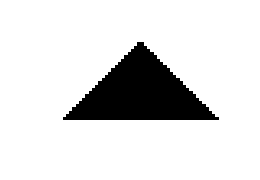

In [3]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.imshow(triangle_mat, cmap = 'gray_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('triangle.png', bbox_inches = 'tight')
plt.show()


# Template

In [4]:
# create blurred image
# need horizontal and vertical kernel (will be the same)
spread = size / 6
kernel = (1.0 / float(spread))* np.ones((spread, spread))

In [5]:
template = signal.convolve(triangle_mat, kernel, mode = 'same')

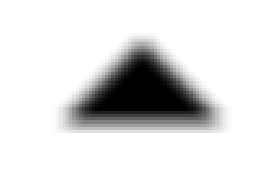

In [6]:
plt.rcParams["figure.figsize"] = [4, 4]
plt.imshow(template, cmap = 'gray_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('template.png', bbox_inches = 'tight')
plt.show()

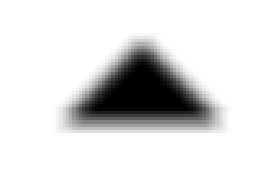

In [7]:
# or use uniform filter from scipy
template_filter = ndimage.uniform_filter(triangle_mat, size = spread)
plt.rcParams["figure.figsize"] = [4, 4]
plt.imshow(template_filter, cmap = 'gray_r')
plt.axis("off")
plt.grid(True)
plt.show()

# Rotation

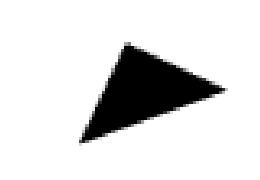

In [8]:
rotate = misc.imrotate(triangle_mat, angle = 20)
plt.rcParams["figure.figsize"] = [4, 4]
plt.imshow(rotate, cmap = 'gray_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('rotation.png', bbox_inches = 'tight')
plt.show()

# Shear

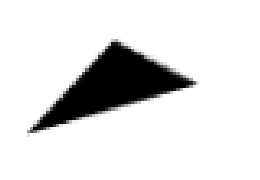

In [9]:
shear_mat = transform.AffineTransform(shear = 0.4) # shear 0 - 0.6 seems to work well for this
shear = transform.warp(rotate, shear_mat.inverse)
plt.rcParams["figure.figsize"] = [4, 4]
plt.imshow(shear, cmap = 'gray_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('shear.png', bbox_inches = 'tight')
plt.show()

# Scale

C:\Users\gjkoplik\Anaconda2\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


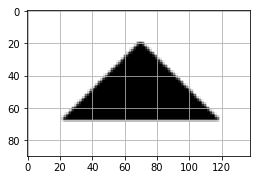

In [10]:
scale = transform.rescale(triangle_mat, scale = 2)
plt.rcParams["figure.figsize"] = [4, 4]
plt.imshow(scale, cmap = 'gray_r')
# plt.axis("off")
plt.grid(True)
plt.show()

# Randomly generate triangles to compile into image

In [11]:
# set seed
random.seed(27705)

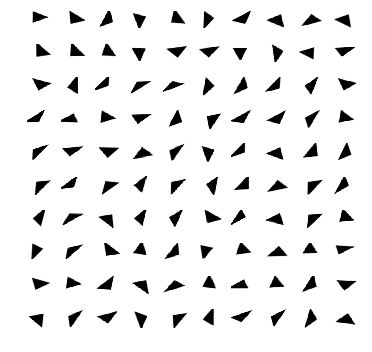

In [12]:
# make list to hold each numpy matrix triangle
triangles = []
# fill in scaled, rotated, and sheared triangles
num_triangles = 100
for i in range(num_triangles):
    # start with original triangle matrix
    temp = np.copy(triangle_mat)
    # scale by random value between 0.75 and 1.25
    scale_factor = random.uniform(0.75, 1.25)
    temp = transform.rescale(temp, scale = scale_factor)
    # rotate by random value between 0 and 360
    rotate_factor = random.uniform(0, 360)
    temp = misc.imrotate(temp, angle = rotate_factor)
    # shear by random value between 0 and 0.6
    shear_factor = random.uniform(0, 0.6)
    shear_mat = transform.AffineTransform(shear = shear_factor)
    temp = transform.warp(temp, shear_mat.inverse)
    # plot (note placements are indexed starting at 1, not 0)
    plt.rcParams["figure.figsize"] = [6, 6]
    plt.subplot(sqrt(num_triangles), sqrt(num_triangles), i + 1)
    plt.imshow(temp, cmap = 'gray_r')
    plt.axis("off")
    plt.grid(True)
    # save the matrix in the list of triangles
    triangles.append(temp)
plt.show()

# Make an image on which to run normalized cross-correlation

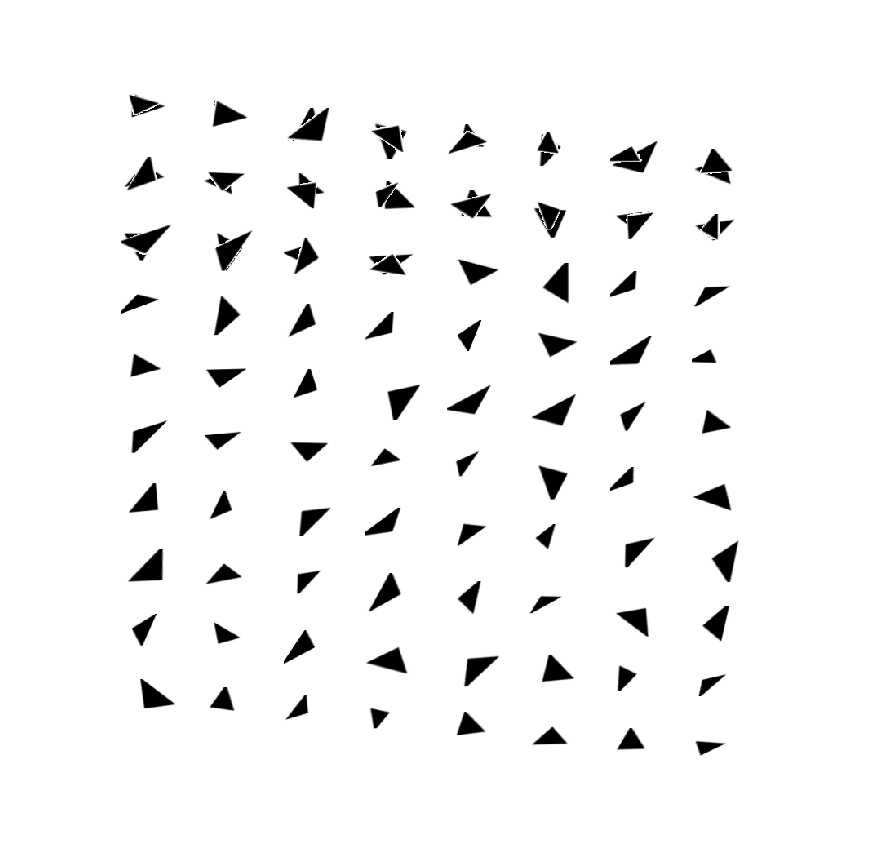

In [13]:
# create an "empty" image
imsize = 1000
image = np.zeros((imsize, imsize))
j = 0
for i in range(num_triangles):
    # initialize row and column start points
    # try inside imsize x imsize interior
    # grid-ish with no border issues later
    row = (i * imsize / num_triangles) % (imsize - 200) + 100
    col = (j * imsize / num_triangles) % (imsize - 200) + 100
    j += imsize / num_triangles
    # grab a triangle from the list
    tri = triangles[i]
    # place just the black of triangles (no background) into image
    np.place(arr = image[row: row + tri.shape[0], col: col + tri.shape[1]], \
             mask = tri != 0, \
             vals = tri[tri != 0])
# plot the final image
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(image, cmap = 'gray_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('image.png', bbox_inches = 'tight')
plt.show()



# Make an image with more interesting background

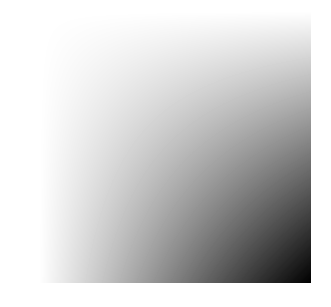

In [14]:
imsize = 1000

# make the background
temp = range(imsize)
temp_scale = [ i * 1.0 / imsize for i in temp]
# bkgrd = np.tile(temp_scale, (imsize, 1))
bkgrd = np.outer(temp_scale, temp_scale)
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(bkgrd, cmap = 'gray_r', vmin = 0, vmax = 1)
plt.axis("off")
plt.grid(True)
plt.show()


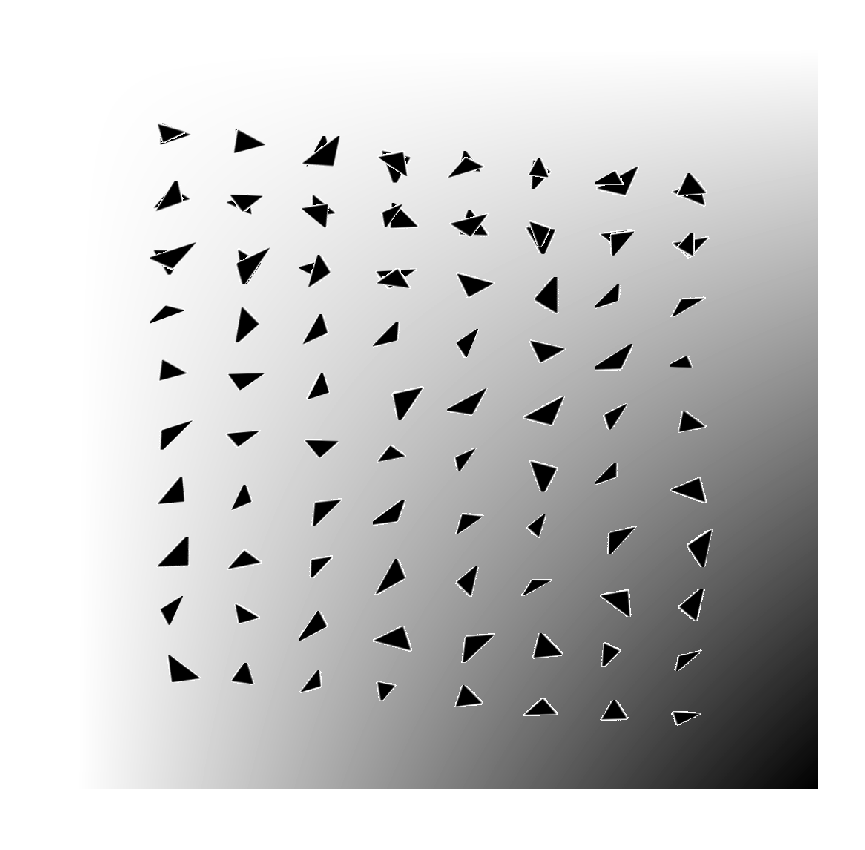

In [15]:
imsize = 1000

# make the background
temp = range(imsize)
temp_scale = [ i * 1.0 / imsize for i in temp]
bkgrd = np.outer(temp_scale, temp_scale)

j = 0
for i in range(num_triangles):
    # initialize row and column start points
    # try inside imsize x imsize interior
    # grid-ish with no border issues later
    row = int((i * imsize / num_triangles) % (imsize - 200) + 100)
    col = int((j * imsize / num_triangles) % (imsize - 200) + 100)
    j += imsize / num_triangles
    # grab a triangle from the list
    tri = triangles[i]
    # place just the black of triangles (no white background) into image
    np.place(arr = bkgrd[row: row + int(tri.shape[0]), col: col + int(tri.shape[1])], \
             mask = tri != 0, \
             vals = tri[tri != 0])
# pad with zeros to avoid non-maximum supression edge issues later
bkgrd = np.pad(bkgrd, pad_width = 50, mode = 'constant')    

plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(bkgrd, cmap = 'gray_r', vmin = 0, vmax = 1)
plt.axis("off")
plt.grid(True)
# plt.savefig('background.png', bbox_inches = 'tight')
plt.show()

# Run the Convolution (One Template Angle)

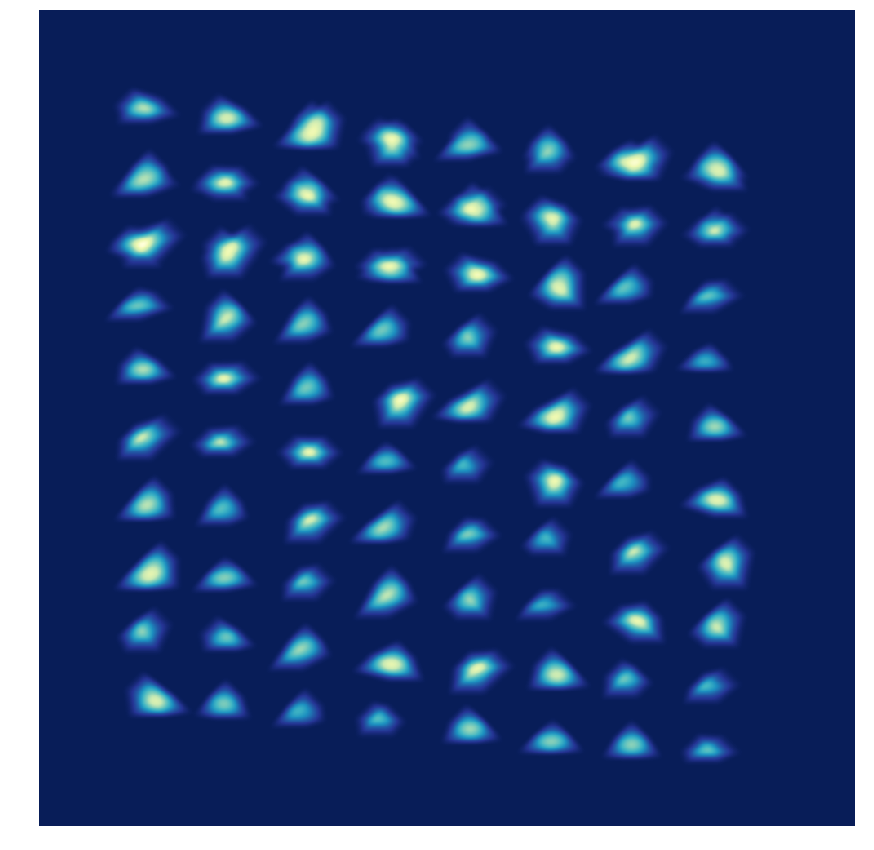

In [16]:
conv = signal.convolve(image, template, mode = 'same')
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(conv, cmap = 'YlGnBu_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('conv_image.png', bbox_inches = 'tight')
plt.show()

# Run it on the triangles with background

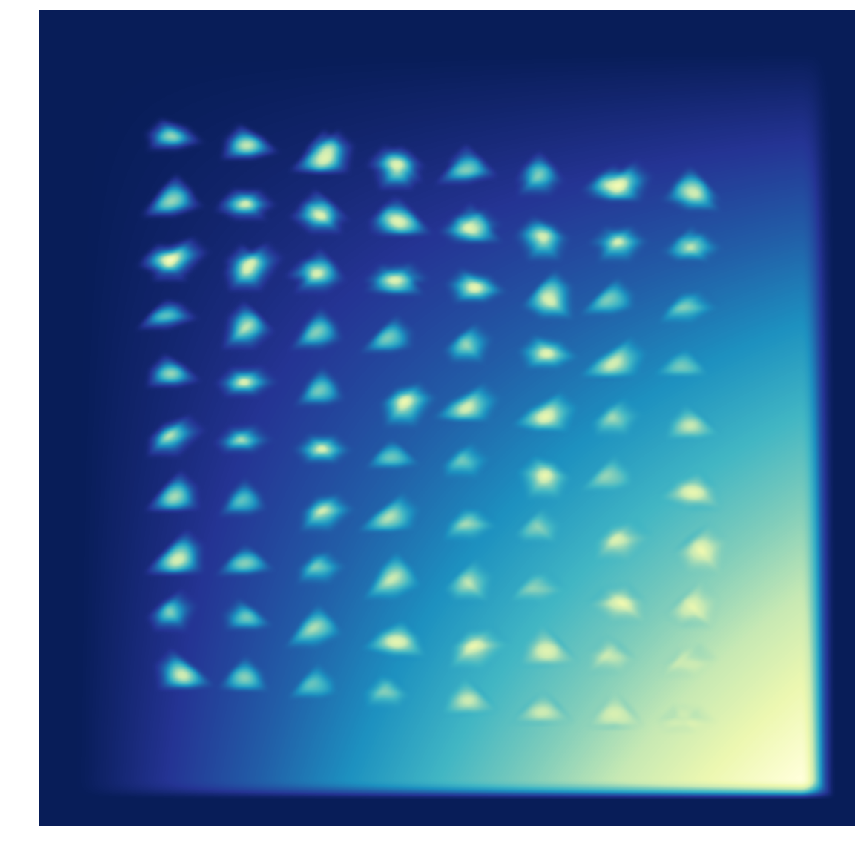

In [17]:
conv_bkgrd = signal.convolve(bkgrd, template, mode = 'same')
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(conv_bkgrd, cmap = 'YlGnBu_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('conv_background.png', bbox_inches = 'tight')
plt.show()

# Implementing non-maximum suppression

In [18]:
# non-maximum suppression
# set a threshold
thresh = 1500
# create list to hold max_points (x and y separate)
max_points_x = []
max_points_y = []
# work with a copy of convolution so don't need to keep rerunning conv above when implementing
conv_copy = np.copy(conv)
while True:
    # check if below threshold
    if np.amax(conv_copy) < thresh:
        break
    # store the max_point
    max_point = np.unravel_index(np.argmax(conv_copy), dims = conv_copy.shape)
    max_points_x.append(max_point[1])
    max_points_y.append(max_point[0])
    # reset the points around it (size of template) to zero
    #     a little bit bigger than the size of the template
    bigger = 1.2
    conv_copy[(max_point[0] - int(bigger * (size / 2))): (max_point[0] + int(bigger * (size / 2) + 2)), \
              (max_point[1] - int(bigger * (size / 2))): (max_point[1] + int(bigger * (size / 2) + 2))] \
        = np.zeros((int(bigger * size), int(bigger * size)))
    

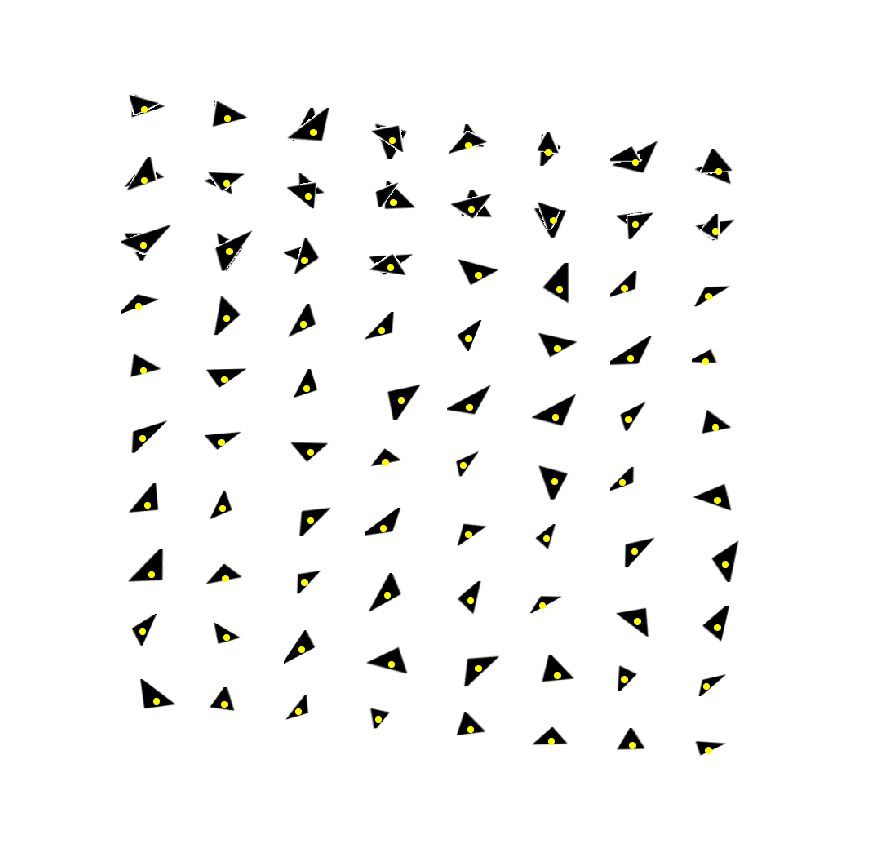

In [19]:
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(image, cmap = 'gray_r')
plt.scatter(max_points_x, max_points_y, c = 'yellow') 
plt.axis("off")
plt.grid(True)
# plt.savefig('image_points.png', bbox_inches = 'tight')
plt.show()

# Repeat for with background

In [20]:
# non-maximum suppression
# set a threshold
# note I changed this threshold and saved several resulting images as used in my write-up
thresh = 2000
# create list to hold max_points (x and y separate)
max_points_x = []
max_points_y = []
# work with a copy of convolution so don't need to keep rerunning conv above when implementing
conv_copy = np.copy(conv_bkgrd)
while True:
    # check if below threshold
    if np.amax(conv_copy) < thresh:
        break
    # store the max_point
    max_point = np.unravel_index(np.argmax(conv_copy), dims = conv_copy.shape)
    max_points_x.append(max_point[1])
    max_points_y.append(max_point[0])
    # reset the points around it (size of template) to zero
    #     a little bit bigger than the size of the template
    bigger = 1.2
    conv_copy[(max_point[0] - int(bigger * (size / 2))): (max_point[0] + int(bigger * (size / 2) + 2)), \
              (max_point[1] - int(bigger * (size / 2))): (max_point[1] + int(bigger * (size / 2) + 2))] \
        = np.zeros((int(bigger * size), int(bigger * size)))
    

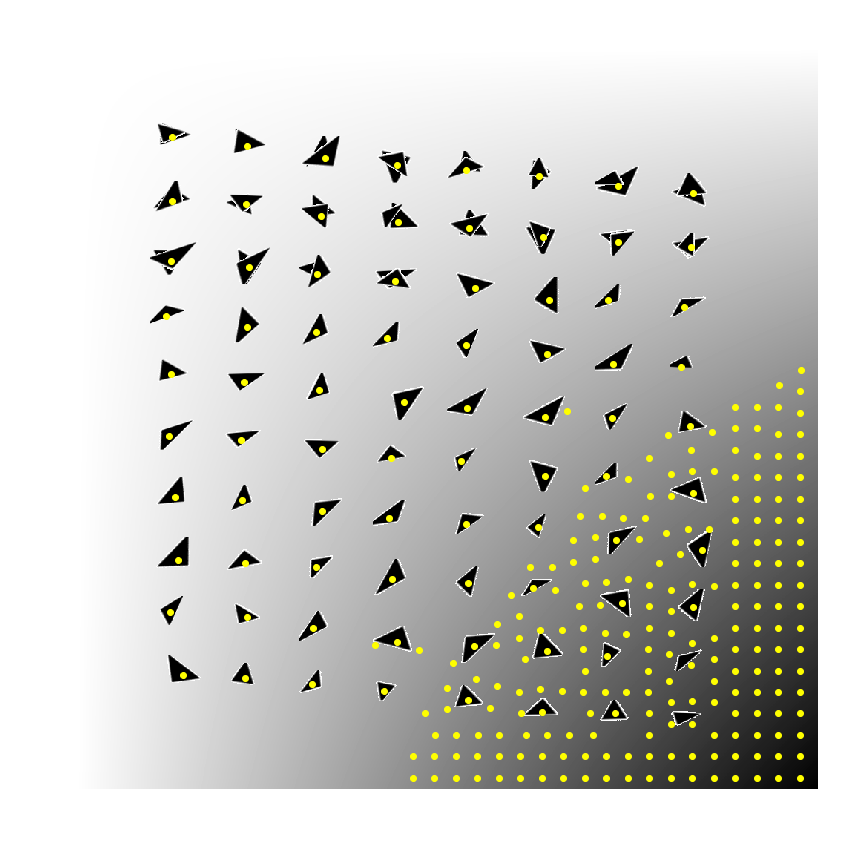

In [21]:
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(bkgrd, cmap = 'gray_r')
plt.scatter(max_points_x, max_points_y, c = 'yellow') 
plt.axis("off")
plt.grid(True)
# plt.savefig('background_points_conv_2000.png', bbox_inches = 'tight')
plt.show()

# Normalized Cross-Correlation

In [22]:
# function to normalize image
# take image (im) as input
# subtracts the mean and divides by frobenius norm of the mean-subtracted image
def norm_im(im):
    return (im - np.mean(im)) / np.linalg.norm(im - np.mean(im) + 0.00000001, ord = 'fro')
    # needs the + 0.00000001 for when window is all zeros (i.e. mean zero => frob norm zero => dividing by zero)

# function to perform normalized cross-correlation
# requires image (im) and template
# note this function only runs correctly if there is a "center" pixel
#     e.g. an 11 x 11 window's center pixel is [6, 6]
def cross_cor(im, template):
    # normalize the template
    # (subtract the mean and divide by frobenius norm of the mean-subtracted template)
    temp_norm = norm_im(template)
    # note the actual size of the image pre-padding
    num_im_rows = int(np.shape(im)[0])
    num_im_cols = int(np.shape(im)[1])
    # note the size of the template
    num_temp_rows = int(np.shape(template)[0])
    num_temp_cols = int(np.shape(template)[1])
    # note the largest dimension of the template for padding
    max_temp_size = int(max(np.shape(template)))
    # pad the image with the edge values to do a "same" convolution
    im = np.pad(im, pad_width = max_temp_size, mode = 'edge')
    # note the first "real" point is now [max_temp_size, max_temp_size]
    # create empty cross correlation image (same size as im)
    cross_cor_image = np.zeros((num_im_rows, num_im_cols))
    # loop over points (i, j) in padded image
    for i in range(max_temp_size, max_temp_size + num_im_rows):
        for j in range(max_temp_size, max_temp_size + num_im_cols):
            # grab the relevant window centered at (i, j)
            window = im[(i - (num_temp_rows / 2)): (i + (num_temp_rows / 2) + 1), \
                        (j - (num_temp_cols / 2)): (j + (num_temp_cols / 2) + 1)]
            # normalize the window
            win_norm = norm_im(window)
            # sanity check size of window equals size of template
            if np.shape(win_norm) != np.shape(temp_norm):
                print "Window size not equal to template size"
                print "Window size: ", np.shape(win_norm)
                print "Template size: ", np.shape(temp_norm)
            # compare the normalized window to the normalized template
            # set the (i, j)th value of cross_cor_image
            #   to the dot product of the flattened matrices
            cross_cor_image[i - max_temp_size, j - max_temp_size] = np.dot(win_norm.flatten(), temp_norm.flatten())
    return cross_cor_image

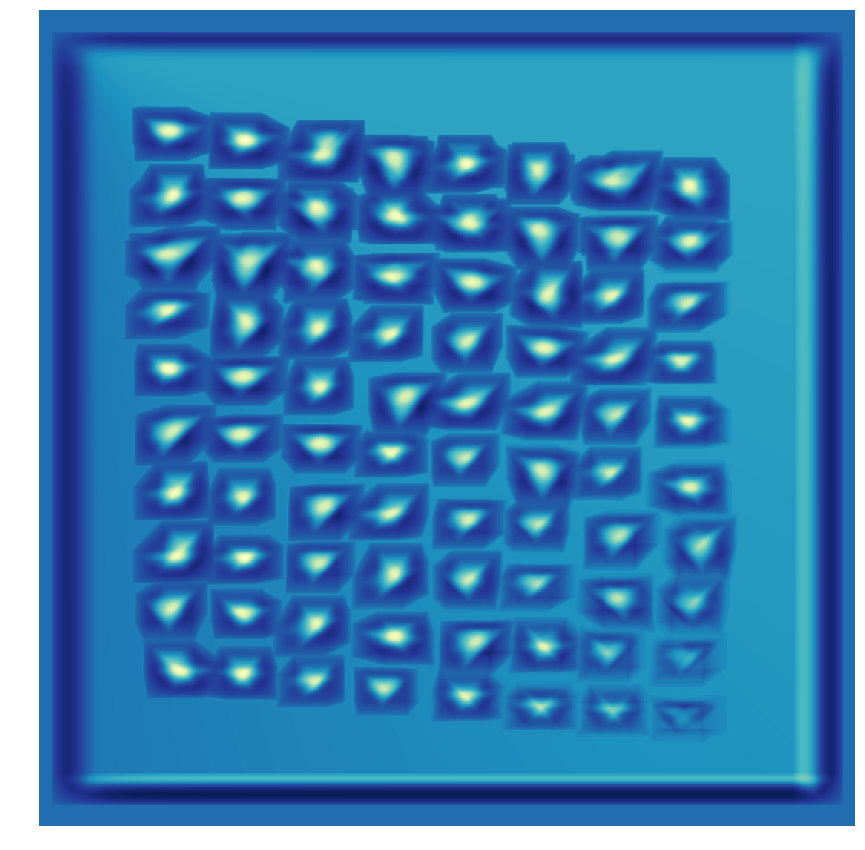

In [23]:
test = cross_cor(bkgrd, template)
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(test, cmap = 'YlGnBu_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor.png', bbox_inches = 'tight')
plt.show()

# Demonstrating Importance of Normalization

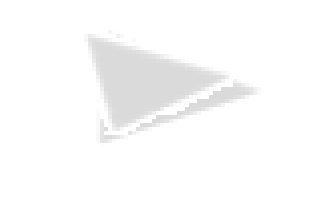

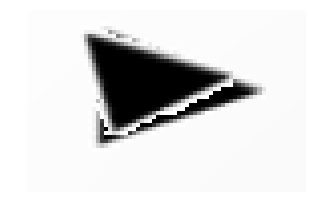

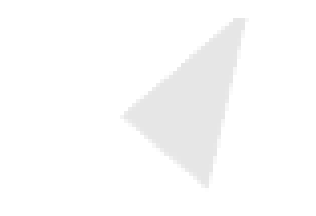

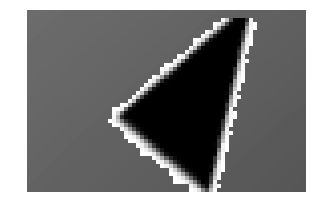

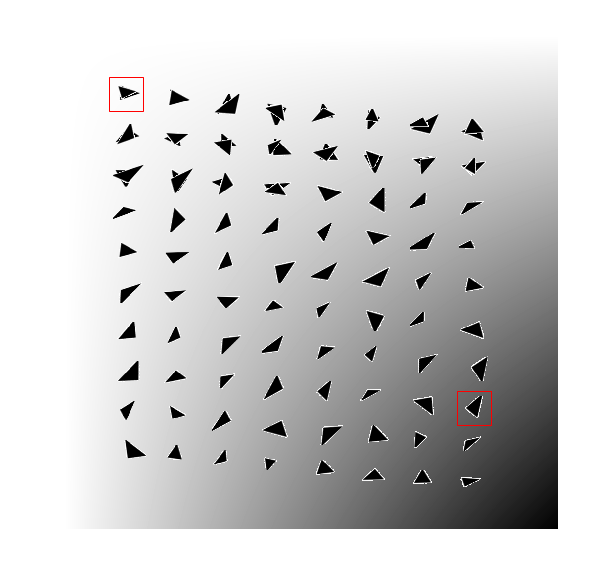

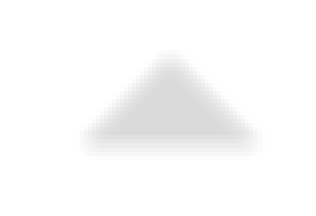

In [24]:
# grab two windows from top left and bottom right of bkgrd
# grab the relevant window centered at (i, j)

# top left
i0 = 170
j0 = 180
num_temp_rows = int(np.shape(template)[0])
num_temp_cols = int(np.shape(template)[1])
window = bkgrd[(i0 - (num_temp_rows / 2)): (i0 + (num_temp_rows / 2) + 1), \
            (j0 - (num_temp_cols / 2)): (j0 + (num_temp_cols / 2) + 1)]
# normalize the window
win_norm = norm_im(window)
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(win_norm, cmap = 'gray_r', vmin = 0, vmax = 0.3)
plt.axis("off")
plt.grid(True)
# plt.savefig('window_top_left_norm.png', bbox_inches = 'tight')
plt.show()

plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(window, cmap = 'gray_r', vmin = 0, vmax = 1.0)
plt.axis("off")
plt.grid(True)
# plt.savefig('window_top_left.png', bbox_inches = 'tight')
plt.show()

# bottom right (3rd triangle up from bottom-right most triangle)
i1 = 800
j1 = 875
num_temp_rows = int(np.shape(template)[0])
num_temp_cols = int(np.shape(template)[1])
window = bkgrd[(i1 - (num_temp_rows / 2)): (i1 + (num_temp_rows / 2) + 1), \
            (j1 - (num_temp_cols / 2)): (j1 + (num_temp_cols / 2) + 1)]
# normalize the window
win_norm = norm_im(window)
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(win_norm, cmap = 'gray_r', vmin = 0, vmax = 0.3)
plt.axis("off")
plt.grid(True)
# plt.savefig('window_bottom_right_norm.png', bbox_inches = 'tight')
plt.show()

plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(window, cmap = 'gray_r', vmin = 0, vmax = 1.0)
plt.axis("off")
plt.grid(True)
# plt.savefig('window_bottom_right.png', bbox_inches = 'tight')
plt.show()

# create image highlighting values I'm grabbing
# referenced https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots(1)
# Display the image
ax.imshow(bkgrd, cmap = 'gray_r', vmin = 0, vmax = 1.0)

# Create a Rectangle patch
rect0 = patches.Rectangle((140, 135), num_temp_cols, num_temp_cols, linewidth = 1, edgecolor = 'r', facecolor = 'none')
rect1 = patches.Rectangle((845, 770), num_temp_cols, num_temp_cols, linewidth = 1, edgecolor = 'r', facecolor = 'none')

# Add the patch to the Axes
ax.add_patch(rect0)
ax.add_patch(rect1)

plt.axis("off")
plt.grid(True)
# plt.savefig('select_triangles.png', bbox_inches = 'tight')
plt.show()

# normalized template
temp_norm = norm_im(template)
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(temp_norm, cmap = 'gray_r', vmin = 0, vmax = 0.3)
plt.axis("off")
plt.grid(True)
# plt.savefig('template_norm.png', bbox_inches = 'tight')
plt.show()

# Non Max Suppression with Bkgrd

In [25]:
# non-maximum suppression
# set a threshold
thresh = 0.2
# create list to hold max_points (x and y separate)
max_points_x = []
max_points_y = []
# work with a copy of convolution so don't need to keep rerunning conv above when implementing
conv_copy = np.copy(test)
while True:
    # check if below threshold
    if np.amax(conv_copy) < thresh:
        break
    # store the max_point
    max_point = np.unravel_index(np.argmax(conv_copy), dims = conv_copy.shape)
    max_points_x.append(max_point[1])
    max_points_y.append(max_point[0])
    # reset the points around it (size of template) to zero
    #     a little bit bigger than the size of the template
    bigger = 1.2
    conv_copy[(max_point[0] - int(bigger * (size / 2))): (max_point[0] + int(bigger * (size / 2) + 2)), \
              (max_point[1] - int(bigger * (size / 2))): (max_point[1] + int(bigger * (size / 2) + 2))] \
        = np.zeros((int(bigger * size), int(bigger * size)))
    

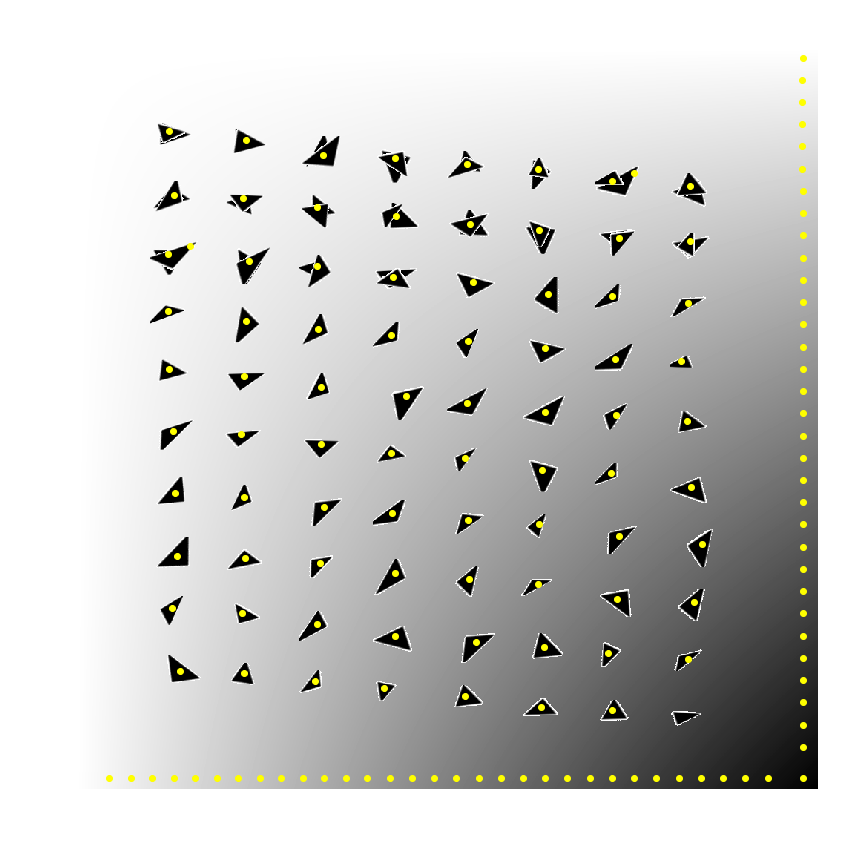

In [26]:
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(bkgrd, cmap = 'gray_r')
plt.scatter(max_points_x, max_points_y, c = 'yellow') 
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_points_0.2.png', bbox_inches = 'tight')
plt.show()

# Use Two Templates for Normalized Cross Correlation

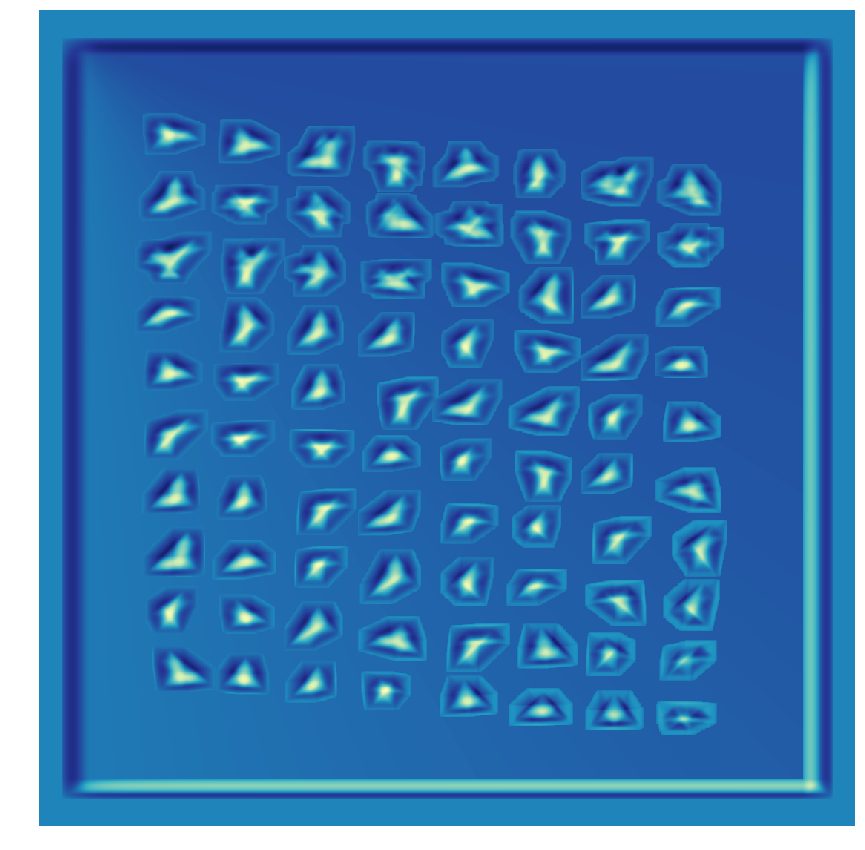

In [28]:
# focus on getting that bottom right-most triangle
# most likely to succeed is flipped template (180 degree rotation)
# it's also smaller so scale it down a bit
template_rotate = misc.imrotate(template, angle = 180)
template_scale = transform.rescale(template_rotate, scale = 0.6)

test_rotate = cross_cor(bkgrd, template_scale)
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(test_rotate, cmap = 'YlGnBu_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_new_template.png', bbox_inches = 'tight')
plt.show()


# Non-max suppression using flipped template

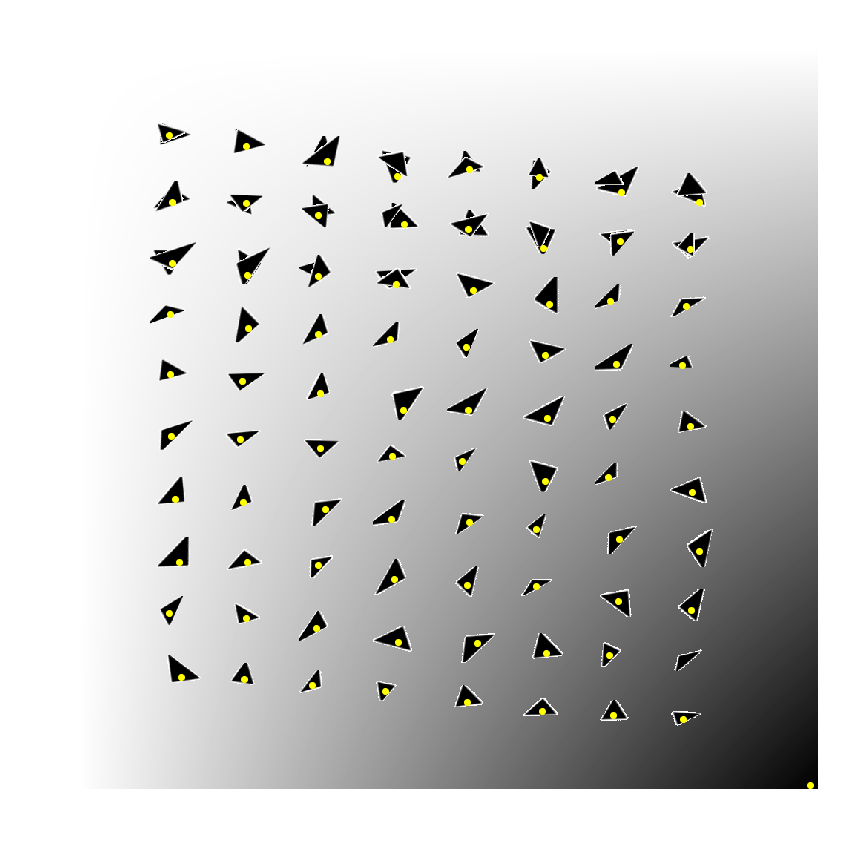

In [29]:
# non-maximum suppression
# set a threshold
thresh = 0.4
# create list to hold max_points (x and y separate)
max_points_x = []
max_points_y = []
# work with a copy of convolution so don't need to keep rerunning conv above when implementing
conv_copy = np.copy(test_rotate)
while True:
    # check if below threshold
    if np.amax(conv_copy) < thresh:
        break
    # store the max_point
    max_point = np.unravel_index(np.argmax(conv_copy), dims = conv_copy.shape)
    max_points_x.append(max_point[1])
    max_points_y.append(max_point[0])
    # reset the points around it (size of template) to zero
    #     a little bit bigger than the size of the template
    bigger = 1.2
    conv_copy[(max_point[0] - int(bigger * (size / 2))): (max_point[0] + int(bigger * (size / 2) + 2)), \
              (max_point[1] - int(bigger * (size / 2))): (max_point[1] + int(bigger * (size / 2) + 2))] \
        = np.zeros((int(bigger * size), int(bigger * size)))

        
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(bkgrd, cmap = 'gray_r')
plt.scatter(max_points_x, max_points_y, c = 'yellow') 
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_points_new_template_0.4.png', bbox_inches = 'tight')
plt.show()        

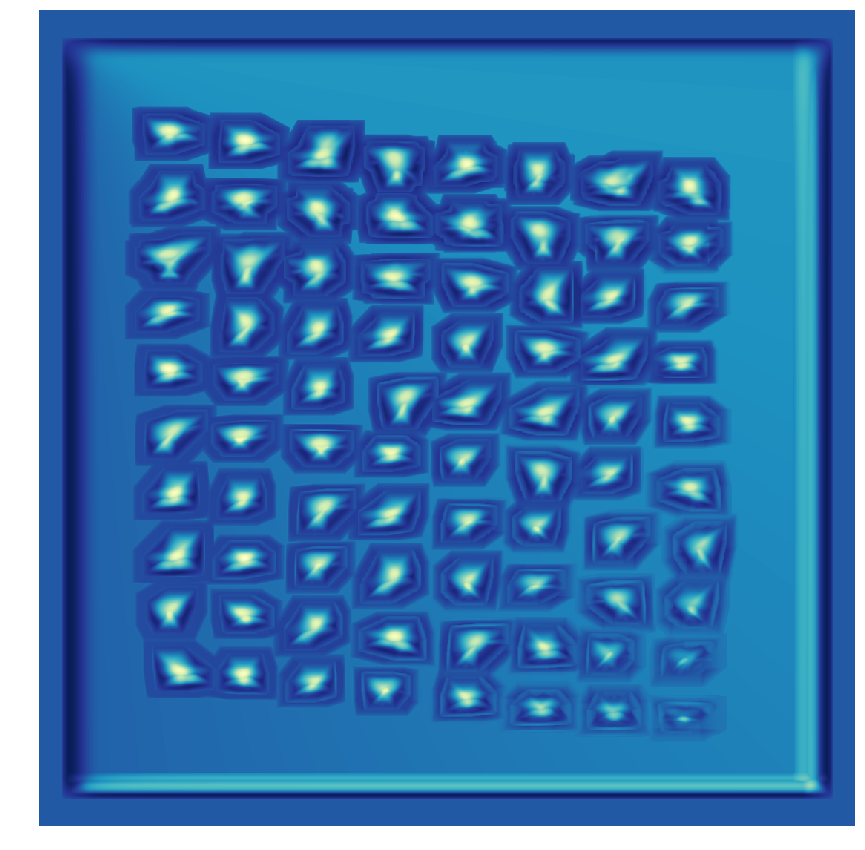

In [30]:
# put two norm cross-corrs in a list
corr_list = [test, test_rotate]

# take max at each point from each norm cross corr
final_corr = np.maximum.reduce(corr_list)

plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(final_corr, cmap = 'YlGnBu_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_best.png', bbox_inches = 'tight')
plt.show()

# Non Max Suppression using best of two templates

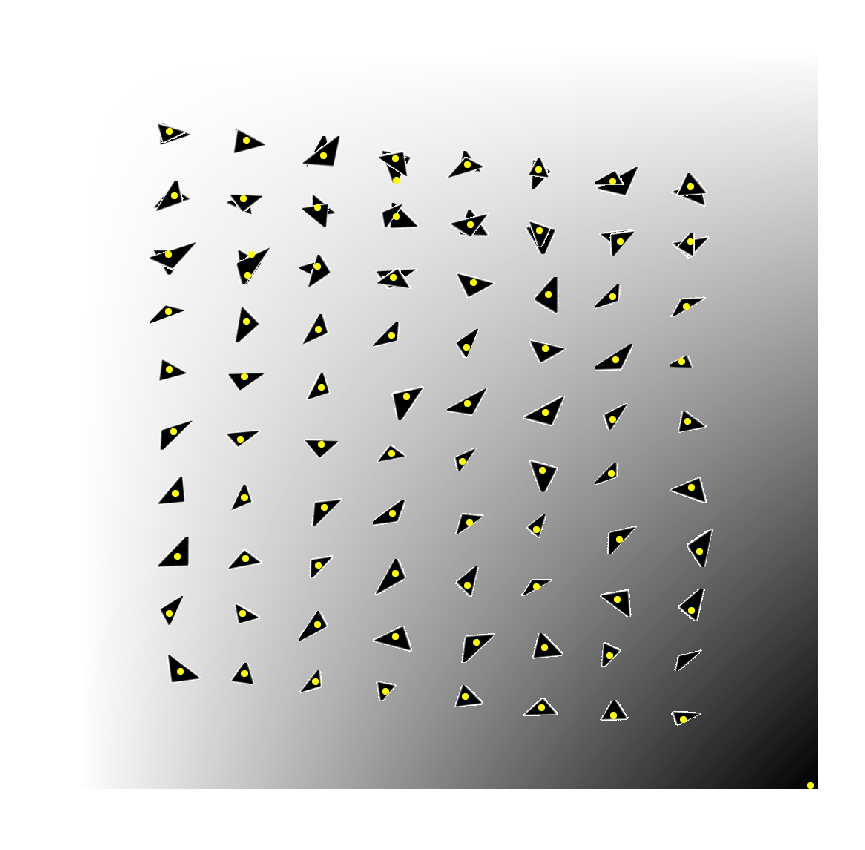

In [31]:
# non-maximum suppression
# set a threshold
thresh = 0.4
# create list to hold max_points (x and y separate)
max_points_x = []
max_points_y = []
# work with a copy of convolution so don't need to keep rerunning conv above when implementing
conv_copy = np.copy(final_corr)
while True:
    # check if below threshold
    if np.amax(conv_copy) < thresh:
        break
    # store the max_point
    max_point = np.unravel_index(np.argmax(conv_copy), dims = conv_copy.shape)
    max_points_x.append(max_point[1])
    max_points_y.append(max_point[0])
    # reset the points around it (size of template) to zero
    #     a little bit bigger than the size of the template
    bigger = 1.2
    conv_copy[(max_point[0] - int(bigger * (size / 2))): (max_point[0] + int(bigger * (size / 2) + 2)), \
              (max_point[1] - int(bigger * (size / 2))): (max_point[1] + int(bigger * (size / 2) + 2))] \
        = np.zeros((int(bigger * size), int(bigger * size)))

        
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(bkgrd, cmap = 'gray_r')
plt.scatter(max_points_x, max_points_y, c = 'yellow') 
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_points_0.2.png', bbox_inches = 'tight')
plt.show()        

# What if we try padding the edges differently

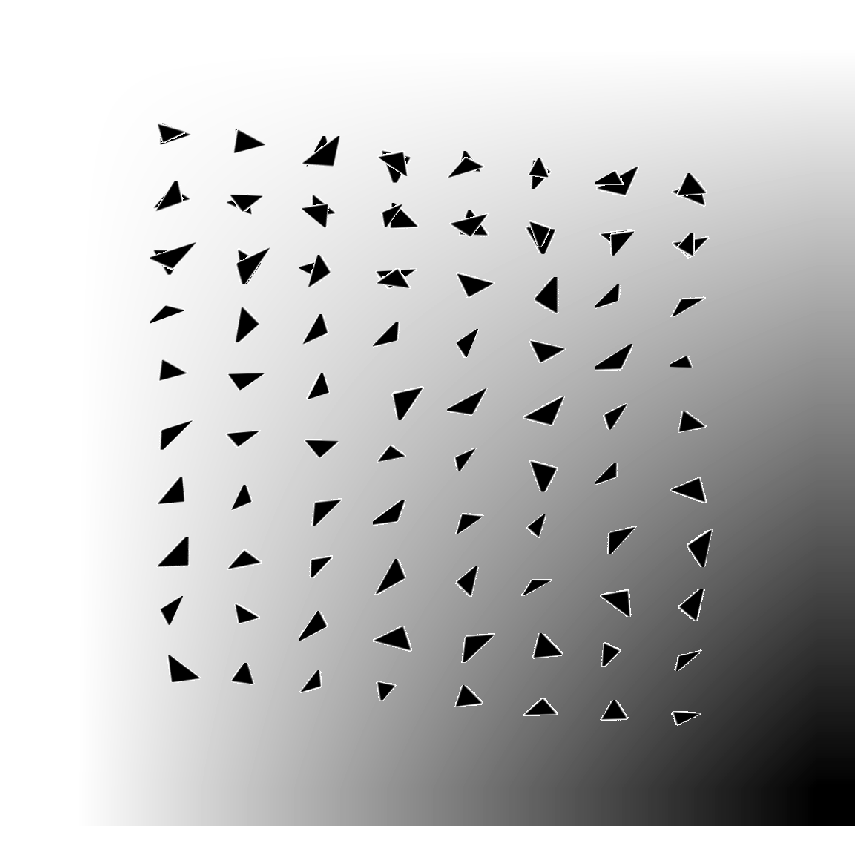

In [32]:
imsize = 1000

# make the background
temp = range(imsize)
temp_scale = [ i * 1.0 / imsize for i in temp]
new_bkgrd = np.outer(temp_scale, temp_scale)

j = 0
for i in range(num_triangles):
    # initialize row and column start points
    # try inside imsize x imsize interior
    # grid-ish with no border issues later
    row = int((i * imsize / num_triangles) % (imsize - 200) + 100)
    col = int((j * imsize / num_triangles) % (imsize - 200) + 100)
    j += imsize / num_triangles
    # grab a triangle from the list
    tri = triangles[i]
    # place just the black of triangles (no white background) into image
    np.place(arr = new_bkgrd[row: row + int(tri.shape[0]), col: col + int(tri.shape[1])], \
             mask = tri != 0, \
             vals = tri[tri != 0])
# pad with edge values to avoid non-maximum supression edge issues later
new_bkgrd = np.pad(new_bkgrd, pad_width = 50, mode = 'edge')

plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(new_bkgrd, cmap = 'gray_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_points_0.2.png', bbox_inches = 'tight')
plt.show()        

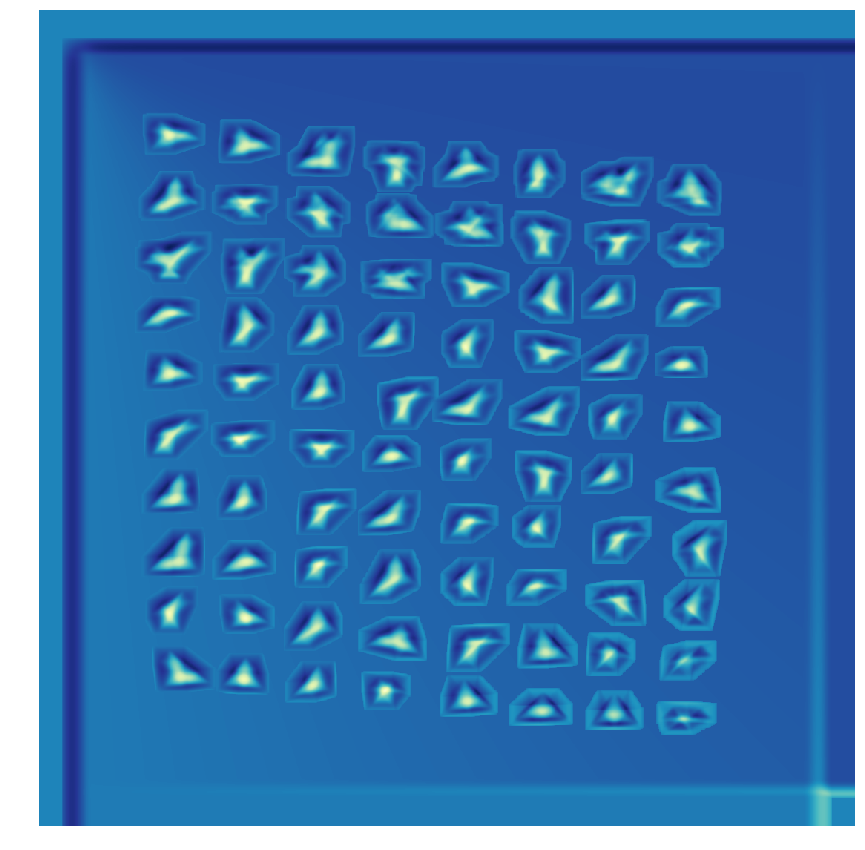

In [33]:
# focus on getting that bottom right-most triangle
# most likely to succeed is flipped template (180 degree rotation)
# it's also smaller so scale it down a bit
template_rotate = misc.imrotate(template, angle = 180)
template_scale = transform.rescale(template_rotate, scale = 0.6)

test_rotate_new_bkgrd = cross_cor(new_bkgrd, template_scale)
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(test_rotate_new_bkgrd, cmap = 'YlGnBu_r')
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_new_padding.png', bbox_inches = 'tight')
plt.show()


# non max suppression on new background norm cross corr

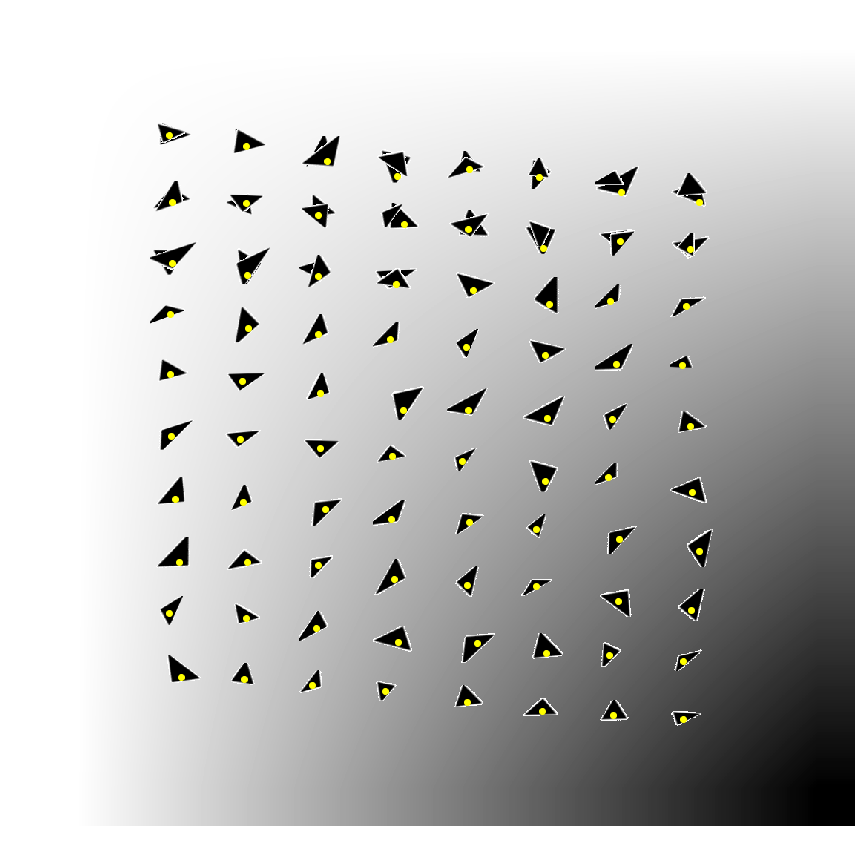

In [34]:
# non-maximum suppression
# set a threshold
thresh = 0.36
# create list to hold max_points (x and y separate)
max_points_x = []
max_points_y = []
# work with a copy of convolution so don't need to keep rerunning conv above when implementing
conv_copy = np.copy(test_rotate_new_bkgrd)
while True:
    # check if below threshold
    if np.amax(conv_copy) < thresh:
        break
    # store the max_point
    max_point = np.unravel_index(np.argmax(conv_copy), dims = conv_copy.shape)
    max_points_x.append(max_point[1])
    max_points_y.append(max_point[0])
    # reset the points around it (size of template) to zero
    #     a little bit bigger than the size of the template
    bigger = 1.2
    conv_copy[(max_point[0] - int(bigger * (size / 2))): (max_point[0] + int(bigger * (size / 2) + 2)), \
              (max_point[1] - int(bigger * (size / 2))): (max_point[1] + int(bigger * (size / 2) + 2))] \
        = np.zeros((int(bigger * size), int(bigger * size)))

        
plt.rcParams["figure.figsize"] = [15, 15]
plt.imshow(new_bkgrd, cmap = 'gray_r')
plt.scatter(max_points_x, max_points_y, c = 'yellow') 
plt.axis("off")
plt.grid(True)
# plt.savefig('cross_cor_points_new_padding_0.36.png', bbox_inches = 'tight')
plt.show()        